# Image Classification on a Raspi with TFLite
by MJRovai @ 23Aug2024

## Import libraries

In [358]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tflite_runtime.interpreter as tflite

In [59]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Main functions

In [60]:
# Function to load labels
def load_labels(filename):
    with open(filename, 'r') as f:
        return [line.strip() for line in f.readlines()]

In [349]:
model_path = "./models/mobilenet_v2_1.0_224_quant.tflite"
img_path = "./images/Cat03.jpg"
labels_path = "./models/labels.txt"

In [350]:
# Load the TFLite model
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [351]:
input_details

[{'name': 'input',
  'index': 171,
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [352]:
output_details

[{'name': 'output',
  'index': 172,
  'shape': array([   1, 1001], dtype=int32),
  'shape_signature': array([   1, 1001], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.09889253973960876, 58),
  'quantization_parameters': {'scales': array([0.09889254], dtype=float32),
   'zero_points': array([58], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [353]:
# Load he image
img = Image.open(img_path)

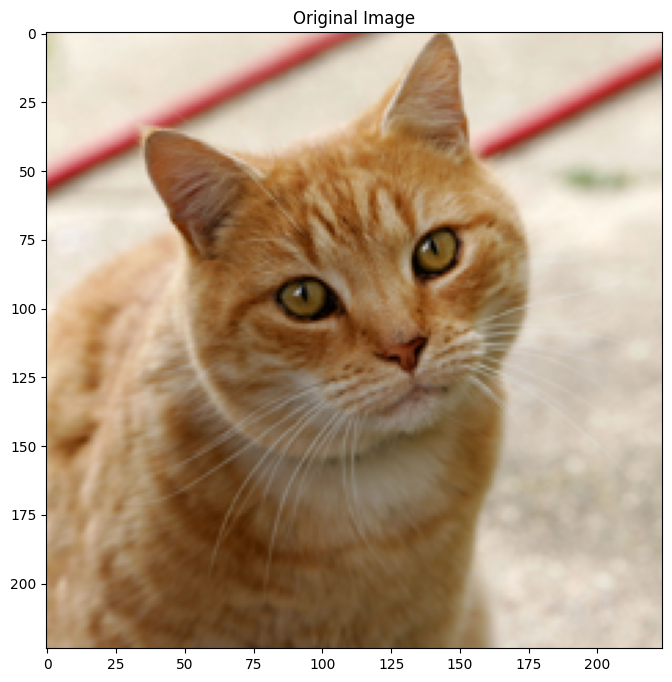

In [83]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
#plt.axis('off')  # This turns off the axis numbers
plt.title("Original Image")
plt.show()

In [354]:
width, height = img.size
channels = len(img.getbands())
shape = (height, width, channels)

print(f"Image shape: {shape}")

Image shape: (1598, 1600, 3)


In [355]:
# Preprocess the image
img = img.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))
input_data = np.expand_dims(img, axis=0)
input_data.shape

(1, 224, 224, 3)

In [356]:
# Get dtype of the input data
input_data.dtype

dtype('uint8')

In [357]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.uint8

The input data dtype is 'uint8', which is compatible with the dtype expected for the model

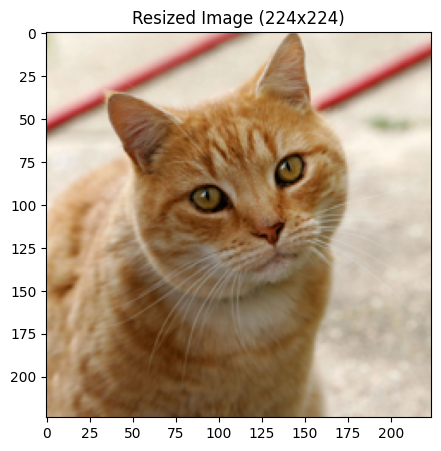

In [359]:
# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
#plt.axis('off')  # This turns off the axis numbers
plt.title("Resized Image (224x224)")
plt.show()

In [365]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 239.2ms


In [366]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]

In [367]:
predictions

array([ 49,  53,  71, ...,  38,  74, 104], dtype=uint8)

In [368]:
predictions.shape

(1001,)

In [369]:
# Get indices of the top k results
top_k_results = 5
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]
top_k_indices

array([283, 286, 282, 288, 479])

In [370]:
# Load labels
labels = load_labels(labels_path)

In [371]:
print(labels[286])
print(labels[283])
print(labels[282])
print(labels[288])
print(labels[479])

Egyptian cat
tiger cat
tabby
lynx
carton


In [372]:
print (predictions[286])
print (predictions[283])
print (predictions[282])
print (predictions[288])
print (predictions[479])

168
171
163
158
143


In [373]:
# Get quantization parameters
scale, zero_point = output_details[0]['quantization']
scale, zero_point

(0.09889253973960876, 58)

In [374]:
# Dequantize the output
dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
dequantized_output

array([-0.8900329, -0.4944627,  1.285603 , ..., -1.9778508,  1.5822806,
        4.549057 ], dtype=float32)

The output (positive and negative numbers) shows that the output probably does not have a Softmax. Checking the model documentation (https://arxiv.org/abs/1801.04381v4): MobileNet V2 typically doesn't include a softmax layer at the output. It usually ends with a 1x1 convolution followed by average pooling and a fully connected layer. So, for getting the probabilities (0 t0 1), we should apply Softmax:

In [375]:
# Apply softmax
exp_output = np.exp(dequantized_output - np.max(dequantized_output))
probabilities = exp_output / np.sum(exp_output)

In [376]:
probabilities 

array([2.1491151e-06, 3.1919305e-06, 1.8928949e-05, ..., 7.2414616e-07,
       2.5466632e-05, 4.9479620e-04], dtype=float32)

In [377]:
# If we sum all values, we can get around 1.
probabilities.sum()

1.0000001

In [378]:
print (probabilities[286])
print (probabilities[283])
print (probabilities[282])
print (probabilities[288])
print (probabilities[479])

0.27741462
0.3732285
0.16919471
0.10319158
0.023410844


In [379]:
for i in range(top_k_results):
    print("\t{:20}: {}%".format(
        labels[top_k_indices[i]],
        (int(probabilities[top_k_indices[i]]*100))))

	tiger cat           : 37%
	Egyptian cat        : 27%
	tabby               : 16%
	lynx                : 10%
	carton              : 2%


### Testing with images

### Define a general Image Classification function

In [380]:
def image_classification(img_path, model_path, labels, top_k_results=5):
    # load the image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    input_data = np.expand_dims(img, axis=0)

    # Inference on Raspi-Zero
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Obtain results and map them to the classes
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    # Get quantization parameters
    scale, zero_point = output_details[0]['quantization']

    # Dequantize the output and apply softmax
    dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
    exp_output = np.exp(dequantized_output - np.max(dequantized_output))
    probabilities = exp_output / np.sum(exp_output)

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {}%".format(
            labels[top_k_indices[i]],
            (int(probabilities[top_k_indices[i]]*100))))

In [381]:
model_path = "./models/mobilenet_v2_1.0_224_quant.tflite"
img_path = "./images/Cat03.jpg"
labels_path = "./models/labels.txt"
labels = load_labels(labels_path)


	[PREDICTION]        [Prob]

	tiger cat           : 37%
	Egyptian cat        : 27%
	tabby               : 16%
	lynx                : 10%
	carton              : 2%


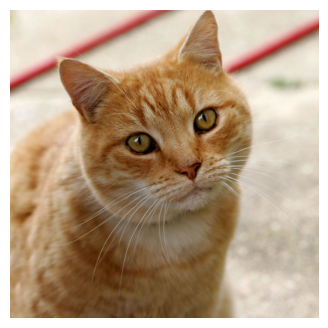

In [382]:
image_classification(img_path, model_path, labels, top_k_results=5)

In [105]:
!ls ./images

background.jpg	car_3.jpg  Cat03.jpg  cat_2.png  dog_3.jpg	ship_1.jpg
car_1.jpg	car_4.jpg  cat_1.jpg  dog_1.jpg  periquito.jpg	ship_2.jpg
car_2.jpg	car_5.jpg  cat_2.jpg  dog_2.jpg  robot.jpg



	[PREDICTION]        [Prob]

	sports car          : 92%
	car wheel           : 2%
	racer               : 2%
	beach wagon         : 1%
	convertible         : 0%


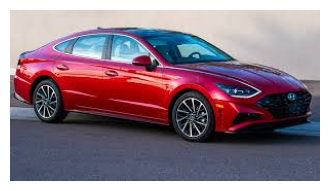

In [106]:
img_path = "./images/car_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	minivan             : 37%
	car wheel           : 16%
	sports car          : 12%
	beach wagon         : 12%
	jeep                : 8%


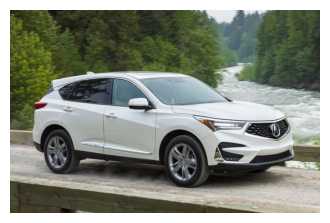

In [107]:
img_path = "./images/car_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	minivan             : 27%
	sports car          : 27%
	grille              : 14%
	beach wagon         : 14%
	car wheel           : 5%


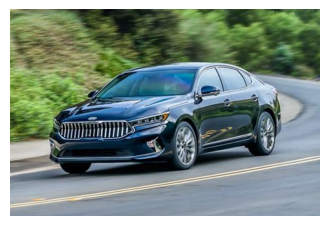

In [108]:
img_path = "./images/car_3.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	sports car          : 68%
	racer               : 14%
	passenger car       : 3%
	cab                 : 3%
	car wheel           : 3%


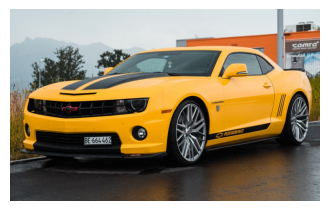

In [109]:
img_path = "./images/car_4.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	convertible         : 44%
	sports car          : 44%
	grille              : 5%
	minivan             : 1%
	pickup              : 0%


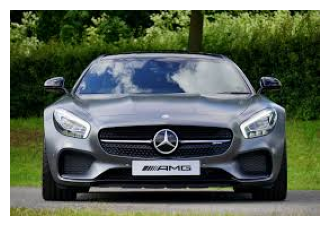

In [110]:
img_path = "./images/car_5.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	tabby               : 68%
	Egyptian cat        : 18%
	tiger cat           : 2%
	hamper              : 1%
	lynx                : 0%


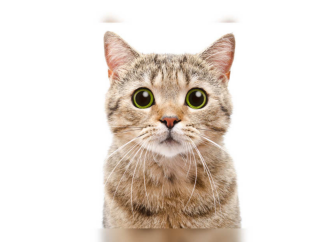

In [111]:
img_path = "./images/cat_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	tiger cat           : 43%
	Egyptian cat        : 24%
	tabby               : 16%
	lynx                : 8%
	carton              : 2%


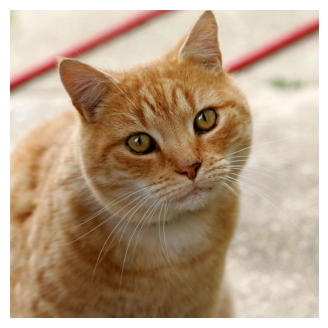

In [112]:
img_path = "./images/cat_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 82%
	golden retriever    : 6%
	bloodhound          : 2%
	kuvasz              : 1%
	Saluki              : 1%


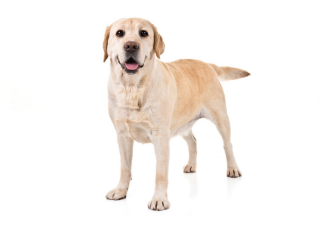

In [113]:
img_path = "./images/dog_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 60%
	dalmatian           : 6%
	Great Pyrenees      : 5%
	kuvasz              : 5%
	tennis ball         : 3%


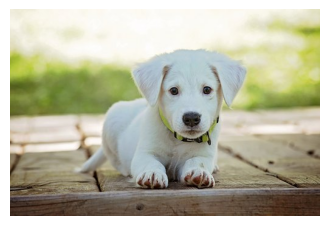

In [114]:
img_path = "./images/dog_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 99%
	Rhodesian ridgeback : 0%
	golden retriever    : 0%
	English foxhound    : 0%
	Great Dane          : 0%


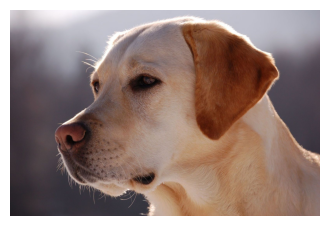

In [115]:
img_path = "./images/dog_3.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	liner               : 78%
	catamaran           : 4%
	container ship      : 4%
	drilling platform   : 2%
	wreck               : 1%


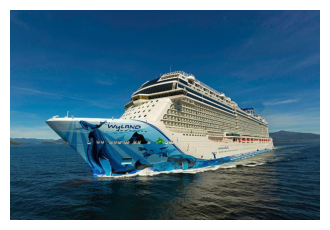

In [116]:
img_path = "./images/ship_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	schooner            : 95%
	pirate              : 2%
	yawl                : 1%
	dock                : 0%
	trimaran            : 0%


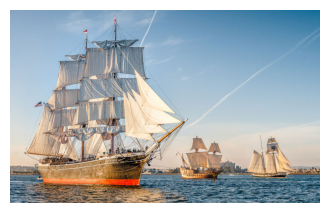

In [117]:
img_path = "./images/ship_2.jpg"
image_classification(img_path, model_path, labels)

In [4]:
ls

10_Image_Classification.ipynb  setup_test.ipynb  usb_camera_image.jpg
images/                        setup_test.py
models/                        Untitled.ipynb


# Inference with a trained model from Edge Impulse Studio

In [459]:
!ls ./models

ei-periquito-vs-robot-img-class-int8-quantized-model.lite
ei-raspi-img-class-float32-model.tflite
ei-raspi-img-class-int8-quantized-model.tflite
labels.txt
mobilenet_v2_1.0_224_quant.ckpt.data-00000-of-00001
mobilenet_v2_1.0_224_quant.ckpt.index
mobilenet_v2_1.0_224_quant.ckpt.meta
mobilenet_v2_1.0_224_quant_eval.pbtxt
mobilenet_v2_1.0_224_quant_frozen.pb
mobilenet_v2_1.0_224_quant_info.txt
mobilenet_v2_1.0_224_quant.tflite
mobilenet_v2_1.0_224_quant.tgz


In [384]:
!ls ./images

background.jpg	car_4.jpg  cat_2.jpg  dog_3.jpg        ship_1.jpg
car_1.jpg	car_5.jpg  cat_2.png  periquito_2.jpg  ship_2.jpg
car_2.jpg	Cat03.jpg  dog_1.jpg  periquito.jpg    teste_img.jpg
car_3.jpg	cat_1.jpg  dog_2.jpg  robot.jpg


In [385]:
labels = ['background', 'periquito', 'robot']

In [420]:
img_path = "./images/robot.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"

In [421]:
    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

In [422]:
input_details

[{'name': 'serving_default_x:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3], dtype=int32),
  'shape_signature': array([  1, 160, 160,   3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [423]:
 output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 177,
  'shape': array([1, 3], dtype=int32),
  'shape_signature': array([1, 3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.00390625, -128),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [424]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.int8

Now, the model is expecting a 'int8' dtype, what means that we should adapt the input image:

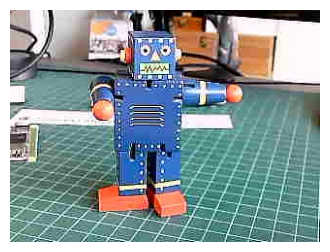

In [425]:
img = Image.open(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [426]:
scale, zero_point = input_details[0]['quantization']
img = img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
input_data = np.expand_dims(img_array, axis=0)
input_data.shape, input_data.dtype

((1, 160, 160, 3), dtype('int8'))

In [427]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 124.9ms


In [428]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]
predictions

array([-128, -128,  127], dtype=int8)

In [429]:
# Get indices of the top k results
top_k_results=3
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]
top_k_indices

array([2, 1, 0])

In [430]:
# Get quantization parameters
scale, zero_point = output_details[0]['quantization']

# Dequantize the output
dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
dequantized_output

array([0.        , 0.        , 0.99609375], dtype=float32)

The model has a softmax in its output, and we should use the raw output of the model as the "probabilities".

In [431]:
# exp_output = np.exp(dequantized_output - np.max(dequantized_output))
# probabilities = exp_output / np.sum(exp_output)
probabilities = dequantized_output

In [432]:
print("\n\t[PREDICTION]        [Prob]\n")
for i in range(top_k_results):
    print("\t{:20}: {:.2f}%".format(
        labels[top_k_indices[i]],
        probabilities[top_k_indices[i]] * 100))


	[PREDICTION]        [Prob]

	robot               : 99.61%
	periquito           : 0.00%
	background          : 0.00%


Let's use a non quantized model

In [433]:
img_path = "./images/periquito.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"

In [434]:
    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

In [435]:
input_details

[{'name': 'serving_default_x:0',
  'index': 0,
  'shape': array([  1, 160, 160,   3], dtype=int32),
  'shape_signature': array([  1, 160, 160,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [436]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 177,
  'shape': array([1, 3], dtype=int32),
  'shape_signature': array([1, 3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [437]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.float32

Now, the model is expecting an input as a float32, so, let's normalize the data to [0,1]. 

In [438]:
input_data = np.expand_dims(np.array(img, dtype=np.float32), axis=0) / 255.0

In [442]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 97.5ms


In [441]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]

In [408]:
predictions

array([5.2281980e-14, 5.8301333e-09, 1.0000000e+00], dtype=float32)

In [409]:
# Get indices of the top k results
top_k_results=3
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

In [410]:
top_k_indices

array([2, 1, 0])

In [411]:
print("\n\t[PREDICTION]        [Prob]\n")
for i in range(top_k_results):
    print("\t{:20}: {}%".format(
        labels[top_k_indices[i]],
            (int(predictions[top_k_indices[i]]*100))))


	[PREDICTION]        [Prob]

	robot               : 100%
	periquito           : 0%
	background          : 0%


### Function to handle any type of models 

In [451]:
def image_classification(img_path, model_path, labels, top_k_results=3, apply_softmax=False):
    # Load the image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    
    input_dtype = input_details[0]['dtype']
    
    if input_dtype == np.uint8:
        input_data = np.expand_dims(np.array(img), axis=0)
    elif input_dtype == np.int8:
        scale, zero_point = input_details[0]['quantization']
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
        input_data = np.expand_dims(img_array, axis=0)
    else:  # float32
        input_data = np.expand_dims(np.array(img, dtype=np.float32), axis=0) / 255.0

    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds

    # Obtain results
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    # Handle output based on type
    output_dtype = output_details[0]['dtype']
    if output_dtype in [np.int8, np.uint8]:
        # Dequantize the output
        scale, zero_point = output_details[0]['quantization']
        predictions = (predictions.astype(np.float32) - zero_point) * scale
    
    if apply_softmax:
        # Apply softmax
        exp_preds = np.exp(predictions - np.max(predictions))
        probabilities = exp_preds / np.sum(exp_preds)
    else:
        probabilities = predictions

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {:.1f}%".format(
            labels[top_k_indices[i]],
            probabilities[top_k_indices[i]] * 100))
    print ("\n\tInference time: {:.1f}ms".format(inference_time))

# Usage:
# image_classification('path_to_image.jpg', 'path_to_model.tflite', labels)


	[PREDICTION]        [Prob]

	periquito           : 99.6%
	robot               : 0.0%
	background          : 0.0%

	Inference time: 121.8ms


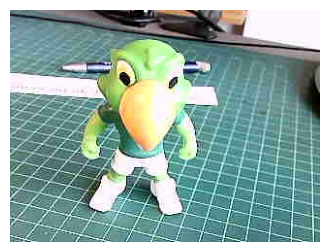

In [452]:
img_path = "./images/periquito.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	periquito           : 100.0%
	background          : 0.0%
	robot               : 0.0%

	Inference time: 97.5ms


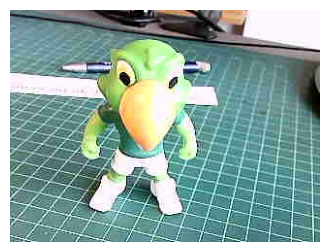

In [453]:
img_path = "./images/periquito.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	robot               : 99.6%
	periquito           : 0.0%
	background          : 0.0%

	Inference time: 127.6ms


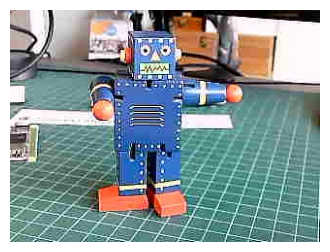

In [454]:
img_path = "./images/robot.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	robot               : 100.0%
	periquito           : 0.0%
	background          : 0.0%

	Inference time: 95.0ms


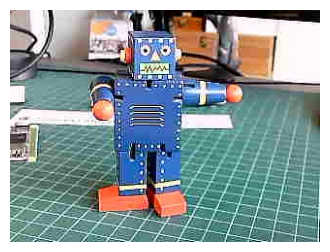

In [455]:
img_path = "./images/robot.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	background          : 99.6%
	robot               : 0.0%
	periquito           : 0.0%

	Inference time: 121.5ms


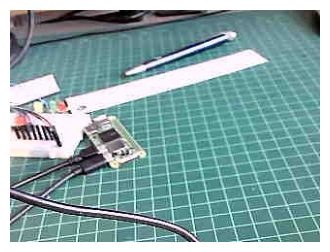

In [456]:
img_path = "./images/background.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	background          : 100.0%
	robot               : 0.0%
	periquito           : 0.0%

	Inference time: 97.2ms


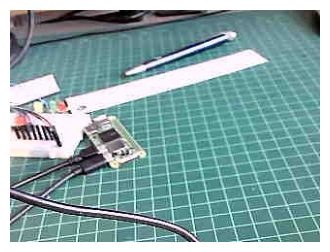

In [457]:
img_path = "./images/background.jpg"
model_path = "./models/ei-raspi-img-class-float32-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	periquito           : 99.6%
	robot               : 0.0%
	background          : 0.0%

	Inference time: 122.5ms


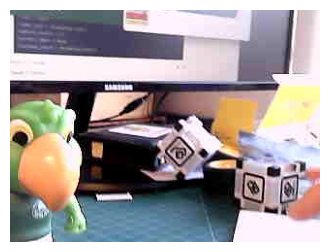

In [458]:
img_path = "./images/periquito_2.jpg"
model_path = "./models/ei-raspi-img-class-int8-quantized-model.tflite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))

### Testing a smaller model 


	[PREDICTION]        [Prob]

	periquito           : 96.1%
	robot               : 3.9%
	background          : 0.0%

	Inference time: 11.1ms


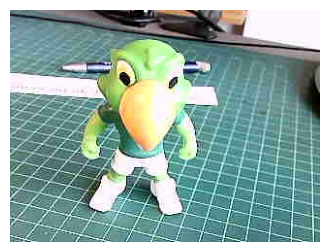

In [464]:
img_path = "./images/periquito.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	robot               : 96.5%
	background          : 2.3%
	periquito           : 1.6%

	Inference time: 11.0ms


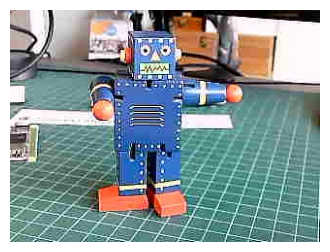

In [461]:
img_path = "./images/robot.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	background          : 51.6%
	periquito           : 46.1%
	robot               : 2.3%

	Inference time: 11.0ms


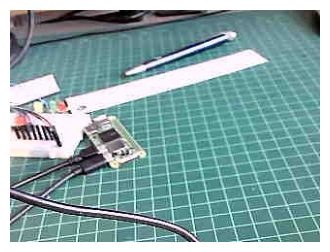

In [462]:
img_path = "./images/background.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))


	[PREDICTION]        [Prob]

	periquito           : 63.7%
	background          : 19.1%
	robot               : 17.2%

	Inference time: 13.5ms


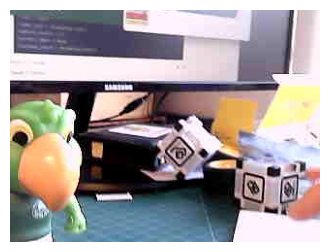

In [463]:
img_path = "./images/periquito_2.jpg"
model_path = "./models/ei-periquito-vs-robot-img-class-int8-quantized-model.lite"
labels = ['background', 'periquito', 'robot']
image_classification(img_path, model_path, labels, top_k_results=len(labels))